**Грамматика**

```
expression ->
    relation {logic relation}

relation ->
    smplStmt [ relOp smplStmt ]

relOp ->
    < | <= | = | /> | > | >=

smplStmt ->
    [ <унарная аддитивная операция> ] <слагаемое>  {<бинарная аддитивная операция> <слагаемое> }

<слагаемое> ->
    <множитель> {<мультипликативная операция> <множитель> }

<множитель> ->
    <первичное> {** <первичное> } |
    abs <первичное> |
    not <первичное>

<первичное> ->
    <числовой литерал> |
    <имя>  |
    ( <выражение> )

<логическая операция> ->
    and | or | xor



<бинарная аддитивная операция> ->
    + | - | &

<унарная аддитивная операция> ->
    + | -
<мультипликативная операция> ->
    * | ! | mod | rem

<операции высшего приоритета> ->
    ** |  abs |  not
```

```
<программа> ->
    <блок>

<блок> ->
    { <список операторов> }

<список  операторов> ->
    <оператор> <хвост>

<хвост> ->
    ; <оператор> <хвост>  |  \eps
```

In [108]:
import typing

class ParseNode:
    data = ""
    children: list[typing.Type["ParseNode"]]
    from_ = -1
    to_ = -1

    def __init__(self, data) -> None:
        self.data = data
        self.children = []
        pass

    def add_child(self, node: typing.Type["ParseNode"]):
        if not len(self.children):
            self.from_ = node.from_
        self.to_ = node.to_

        
        if node.data in ['<proxy>']:
            for ch in node.children:
                self.add_child(ch)
            return
        
        self.children.append(node)

    def print(self, tree = None, parent="", id = "main"):
        from graphviz import Digraph
        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"
        tree.node(id, str(self.data))
        if parent:
            tree.edge(parent, id)
        
        # print("IN:",  self.data, [ch.data for ch in self.children])
        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))
        # print("OUT:",  self.data, [ch.data for ch in self.children])
            
        return tree

def make_parse_lexem(lexem:str):
    def parse_lexem(lexems:typing.List[str], startPos:int):   
        if startPos >= len(lexems):
            return None     
        if lexems[startPos] == lexem:
            tree = ParseNode(lexem)
            tree.from_ = startPos
            tree.to_ = startPos + 1
            return tree
        return None
    return parse_lexem


def make_choice(rules):
    def combinator(lexems:typing.List[str], startPos:int):
        for rule in rules:
            node = rule(lexems, startPos)
            if not node:
                continue
            tree = ParseNode("<proxy>")
            tree.add_child(node)
            return tree

        return None
    return combinator

def make_combine(rules):
    def combinator(lexems:typing.List[str], startPos:int):
        tree = ParseNode('<proxy>')
        curPos = startPos
        for rule in rules:
            node = rule(lexems, curPos)
            if not node:
                return None
            
            tree.add_child(node)
            curPos = node.to_
        return tree
    return combinator

def make_loop(rule):
    def looper(lexems:typing.List[str], startPos:int):
        tree = ParseNode("<proxy>")
        tree.from_ = startPos
        tree.to_ = startPos

        curPos = startPos
        while True:           
            node = rule(lexems, curPos)
            if not node:
                break
            curPos = node.to_
            tree.add_child(node)
            
        return tree
    return looper

def make_optional(rule):
    def ret_empty(pos):
        node = ParseNode('<proxy>')
        node.from_ = pos
        node.to_ = pos
        return node
    
    def opter(lexems:typing.List[str], startPos:int):
        node = rule(lexems, startPos)
        if not node:
            return ret_empty(startPos)
        return node
    return opter








def parse_mult_op(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
            make_parse_lexem('*'),
            make_parse_lexem('!'),
            make_parse_lexem('mod'),
            make_parse_lexem('rem'),
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<мультипликативная операция>'
    return tree


def parse_unar(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
            make_parse_lexem('+'),
            make_parse_lexem('-'),
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<унарная аддитивная операция>'
    return tree


def parse_bin_op(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
            make_parse_lexem('+'),
            make_parse_lexem('-'),
            make_parse_lexem('&'),
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<бинарная аддитивная операция>'
    return tree

def parse_rel_op(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
            make_parse_lexem('<'),
            make_parse_lexem('<='),
            make_parse_lexem('='),
            make_parse_lexem('/>'),
            make_parse_lexem('>'),
            make_parse_lexem('>='),
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<операция отношения>'
    return tree

def parse_log_op(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
            make_parse_lexem('and'),
            make_parse_lexem('or'),
            make_parse_lexem('xor'),
    ])(lexems, startPos)
    if not tree:
        return None
    tree.data = '<логическая операция>'
    return tree

def parse_id(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    if startPos >= len(lexems):
        return None
    tree = ParseNode("<имя>")

    data = lexems[startPos]
    if not data.isalpha():
        return None
    
    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree

def parse_num(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    if startPos >= len(lexems):
        return None
    
    tree = ParseNode("<числовой литерал>")

    try:
        data = float(lexems[startPos])
    except:
        return None
    
    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree

def parse_first(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_combine([
            make_parse_lexem('('),
            parse_expr,
            make_parse_lexem(')'),
        ]),
        parse_id,
        parse_num,
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<первичное>'
    return tree

def parse_mnoz(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_choice([
        make_combine([
            make_parse_lexem('abs'),
            parse_first,
        ]),
        make_combine([
            make_parse_lexem('not'),
            parse_first,
        ]),
        make_combine([
            parse_first,
            make_loop(
                make_combine([
                    make_parse_lexem('**'), parse_first
                ])
            )
        ]),
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<множитель>'
    return tree

def parse_slag(lexems:typing.List[str], startPos:int):
    tree = make_combine([
        parse_mnoz,
        make_loop(make_combine([parse_mult_op, parse_mnoz]))
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<слагаемое>'
    return tree

def parse_smpl_stmt(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_combine([
        make_optional(parse_unar),
        parse_slag,
        make_loop(make_combine([parse_bin_op, parse_slag]))
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = '<простое выражение>'
    return tree

def parse_rel(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    
    tree = make_combine([
        parse_smpl_stmt,
        make_optional(
            make_combine([
                parse_rel_op,
                parse_smpl_stmt
            ]),
        )
    ])(lexems, startPos)
    if not tree:
        return None
    tree.data =  '<отношение>'
    return tree


def parse_expr(lexems:typing.List[str], startPos:int) -> typing.Optional[ParseNode]:
    tree = make_combine([
        parse_rel,
        make_loop(make_combine([parse_log_op, parse_rel]))
    ])(lexems, startPos)
    if not tree:
        return None

    tree.data = "<выражение>"

    return tree
    




['(', '(', '-', '12', '-', '4', '*', '5', ')', '>', '10', ')', 'and', 'not', '(', '10', '>', '(', '10', '*', 'arr', '**', '3', ')', ')']


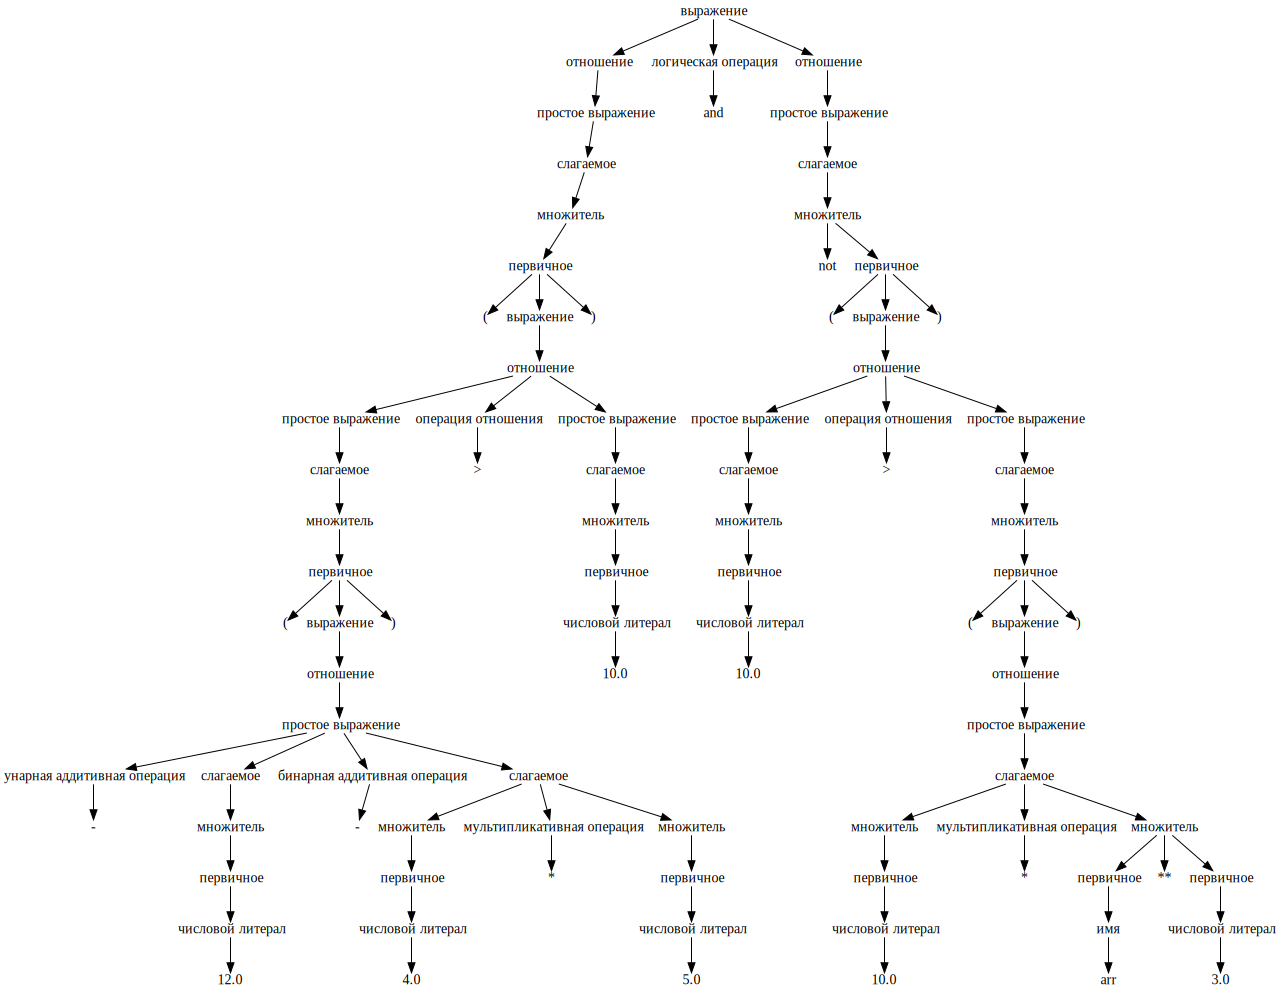

In [113]:
code = "((-12-4*5)>10)and not ( 10 > ( 10 * arr ** 3))"

tokens = []
curPos = 0
while curPos < len(code):
    if code[curPos: min(curPos + 3, len(code))] in ['and', 'not', 'xor', 'mod', 'rem', 'abs']:
        tokens += [code[curPos: min(curPos + 3, len(code))]]
        curPos += 3
    elif code[curPos: min(curPos + 2, len(code))] in ['or', '**', '<=', '>=', '/>']:
        tokens += [code[curPos: min(curPos + 2, len(code))]]
        curPos += 2
    elif code[curPos] in ['+', '-', '*', '/', '>', '<', '=', '&', '(', ')', '{', '}', ';']:
        tokens += [code[curPos]]
        curPos += 1
    elif code[curPos] in [' ', '\t' ,'\n', '\r']:
        curPos += 1
    else:
        startpos = curPos
        while code[curPos].isalpha() or code[curPos].isnumeric() or code[curPos] in ["_", '.']:
            curPos += 1
        tokens += [code[startpos: curPos]]
        if (startpos == curPos):
            print("ERROR")
            break
    # print(tokens[-1])



print(tokens)
tree = parse_expr(tokens, 0)
tree.print()
